# Deep Ensemble

## Theoretic Foundation

Introduced in [Lakshminarayanan, 2017](https://proceedings.neurips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf), Deep Ensembles approximate a posterior distribution over the model weights with a Gaussian mixture model over the output of separately initialized and trained networks. In [Wilson, 2020](https://proceedings.neurips.cc/paper/2020/file/322f62469c5e3c7dc3e58f5a4d1ea399-Paper.pdf) the authors showed that Deep Ensembles can be interpreted as a Bayesian method.

For the Deep Ensembles model the predictive mean is given by the mean taken over $N \in \mathbb{N}$ models $f_{\theta_i}(x^{\star}) = \mu_{\theta_i}(x^{\star})$ that output a mean with different weights $\{\theta_i\}_{i=1}^N$, 

$$
     \mu(x^{\star}) = \frac{1}{N} \sum_{i=1}^N  \mu_{\theta_i}(x^{\star}).
$$

The predictive uncertainty is given by the standard deviation of the predictions of the $N$ different networks, Gaussian ensemble members,

$$
    \sigma(x^{\star}) = \sqrt{\frac{1}{N} \sum_{i=1}^N  \left(\mu_{\theta_i}(x^{\star})-  \mu(x^{\star}) \right)^2}.
$$

##Deep Ensembles GMM

For the Deep Ensembles GMM model, the predictive mean is given by the mean taken over $N \in \mathbb{N}$ models $f_{\theta_i}(x^{\star}) = (\mu_{\theta_i}(x^{\star}), \sigma_{\theta_i}(x^{\star}))$ with different weights $\{\theta_i\}_{i=1}^N$, 

$$
     \mu_g(x^{\star}) = \frac{1}{N} \sum_{i=1}^N  \mu_{\theta_i}(x^{\star}).
$$

The predictive uncertainty is given by the standard deviation of the Gaussian mixture model consisting of the $N$ different networks, Gaussian ensemble members,

$$
    \sigma_g(x^{\star}) = \sqrt{\frac{1}{N} \sum_{i=1}^N  \left(\mu_{\theta_i}(x^{\star})-  \mu_g(x^{\star}) \right)^2+ \frac{1}{N}  \sum_{i=1}^N \sigma_{\theta_i}^2(x^\star)}.
$$

Note that the difference between "Deep Ensembles" and "Deep Ensembles GMM" is that in the latter we also consider the predictive uncertainty output of each individual ensemble member, whereas in the former we only consider the means and the variance of the mean predictions of the ensemble members.

## Imports

In [1]:
import os
import sys

# required to make the path visible to import the tools
# this will change in public notebooks to be "pip install uq-regression-box"
nb_dir = os.path.split(os.path.split(os.getcwd())[0])[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
nb_dir

import tempfile
from functools import partial

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.loggers import CSVLogger

from lightning_uq_box.datamodules import ToyHeteroscedasticDatamodule
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import DeepEnsembleRegression, MVERegression
from lightning_uq_box.viz_utils import (
    plot_calibration_uq_toolbox,
    plot_predictions_regression,
    plot_toy_regression_data,
    plot_training_metrics,
)

plt.rcParams["figure.figsize"] = [14, 5]

In [2]:
seed_everything(0)  # seed everything for reproducibility

Seed set to 0


0

We define a temporary directory to look at some training metrics and results.

## Datamodule

To demonstrate the method, we will make use of a Toy Regression Example that is defined as a [Lightning Datamodule](https://lightning.ai/docs/pytorch/stable/data/datamodule.html). While this might seem like overkill for a small toy problem, we think it is more helpful how the individual pieces of the library fit together so you can train models on more complex tasks.

In [3]:
my_temp_dir = tempfile.mkdtemp()

In [4]:
dm = ToyHeteroscedasticDatamodule()

X_train, y_train, train_loader, X_test, y_test, test_loader = (
    dm.X_train,
    dm.y_train,
    dm.train_dataloader(),
    dm.X_test,
    dm.y_test,
    dm.test_dataloader(),
)

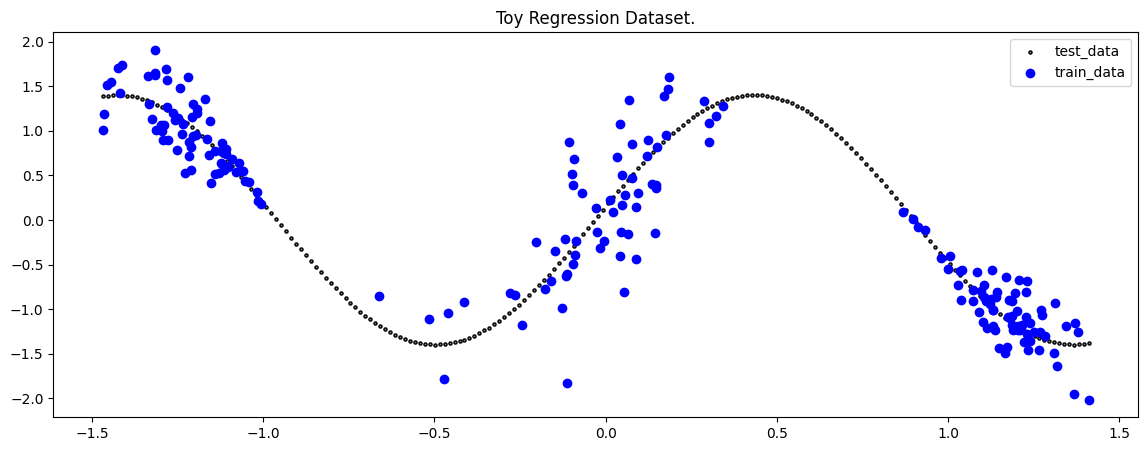

In [5]:
plot_toy_regression_data(X_train, y_train, X_test, y_test)

## Model

For our Toy Regression problem, we will use a simple Multi-layer Perceptron (MLP) that you can configure to your needs. For the documentation of the MLP see [here](https://readthedocs.io/en/stable/api/models.html#MLP). In the case of the Deep Ensemble, we will train 5 differently initialzed base deterministic networks and later combine them into an ensemble for predictions. We will keep track of the model checkpoints of these models and save them manually in our temporary directory. Later we can use these to initialized the different members that make up our Ensemble during prediction, where only the corresponding ensemble member that is needed will be loaded to reduce memory requirements.

In [15]:
n_ensembles = 5
trained_models_nll = []
for i in range(n_ensembles):
    mlp_model = MLP(n_hidden=[50, 50], n_outputs=2, activation_fn=nn.Tanh())
    ensemble_member = MVERegression(
        mlp_model,
        optimizer=partial(torch.optim.Adam, lr=1e-2),
        burnin_epochs=20,
    )
    trainer = Trainer(
        max_epochs=150,
        limit_val_batches=0,
        num_sanity_val_steps=0,
        logger=False,
        enable_checkpointing=False,
    )
    trainer.fit(ensemble_member, dm)
    save_path = os.path.join(my_temp_dir, f"model_nll_{i}.ckpt")
    trainer.save_checkpoint(save_path)
    trained_models_nll.append({"base_model": ensemble_member, "ckpt_path": save_path})

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 2.8 K 
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | loss_fn       | NLL              | 0     
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 2.8 K 
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | loss_fn       | NLL              | 0     
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 2.8 K 
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | loss_fn       | NLL              | 0     
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 2.8 K 
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | loss_fn       | NLL              | 0     
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type             | Params
---------------------------------------------------
0 | model         | MLP              | 2.8 K 
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | loss_fn       | NLL              | 0     
---------------------------------------------------
2.8 K     Trainable params
0         Non-trainable params
2.8 K     Total params
0.011     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


## Construct Deep Ensemble 

In [16]:
deep_ens_nll = DeepEnsembleRegression(n_ensembles, trained_models_nll)

## Prediction

In [17]:
preds = deep_ens_nll.predict_step(X_test)

## Evaluate Predictions

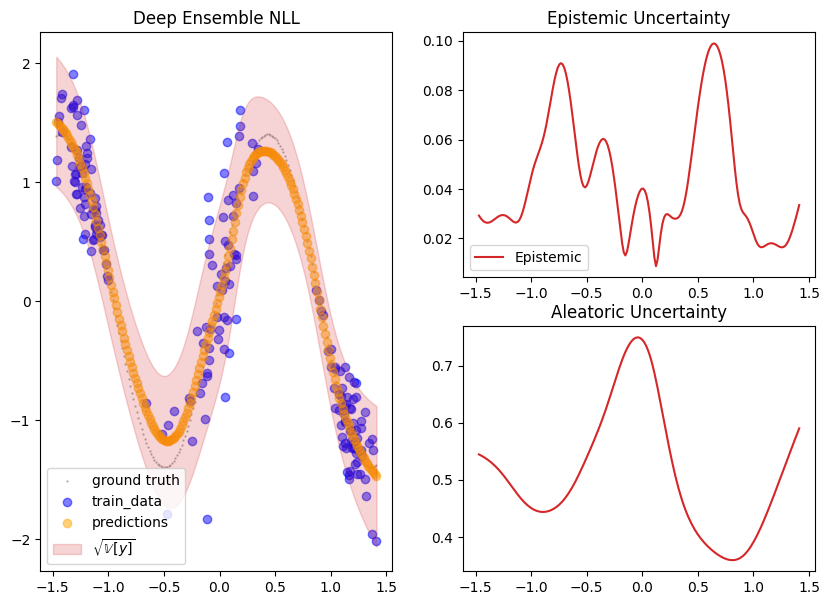

In [18]:
fig = plot_predictions_regression(
    X_train,
    y_train,
    X_test,
    y_test,
    preds["pred"],
    preds["pred_uct"],
    epistemic=preds["epistemic_uct"],
    aleatoric=preds["aleatoric_uct"],
    title="Deep Ensemble NLL",
    show_bands=False,
)

For some additional metrics relevant to UQ, we can use the great [uncertainty-toolbox](https://uncertainty-toolbox.github.io/) that gives us some insight into the calibration of our prediction. For a discussion of why this is important, see ...

<Figure size 1400x500 with 0 Axes>

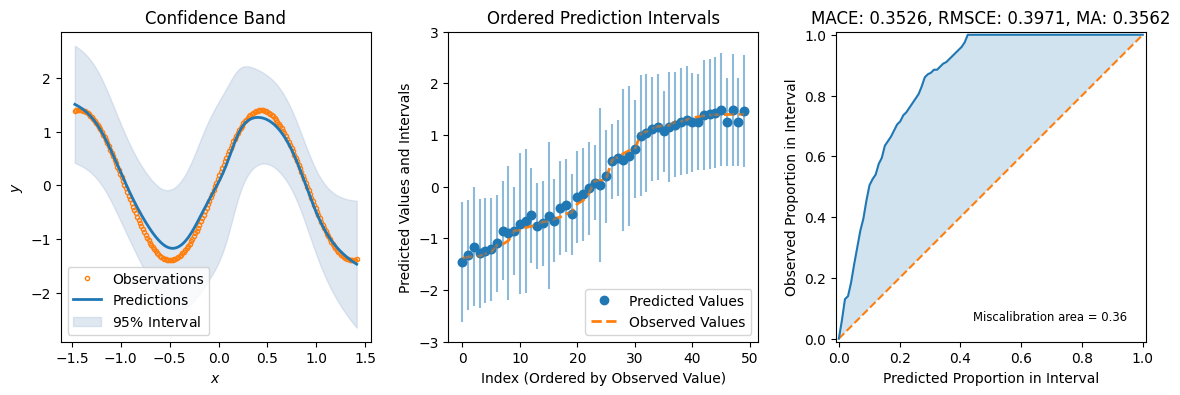

In [21]:
fig = plot_calibration_uq_toolbox(
    preds["pred"].numpy(), preds["pred_uct"].numpy(), y_test.cpu().numpy(), X_test.cpu().numpy()
)

## Additional Resources

Links to othere related literature that might be interesting.